In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# BBC News Article Clustering with Unsupervised Learning

In this project, we explore how unsupervised learning techniques can be used to uncover meaningful patterns in text data — specifically, news articles from the BBC News Classification dataset. This dataset contains over 2,200 articles, each labeled with one of five topics: business, entertainment, politics, sport, or tech.

Although the dataset includes category labels, the goal was to treat the problem as an unsupervised learning task. So I attempted to group the articles into clusters based only on their content, without using the labels during model training.

My objectives are to:
- Apply unsupervised learning by clustering to group similar articles together
- Compare multiple clustering algorithms, including KMeans and Hierarchical Clustering
- Visualize and evaluate the results both quantitatively (with metrics like ARI and homogeneity) and qualitatively (using 2D projections via PCA)

By the end of this process, I aim to assess how well unsupervised models can discover the natural structure of news topics — and how closely their groupings align with the actual categories.

## Goals

- Perform text preprocessing and convert documents to numerical vectors using TF-IDF
- Apply K-Means Clustering to group similar news articles
- Analyze and interpret the resulting clusters

## Dataset Source

- [Learn AI with the BBC - Kaggle Competition](https://www.kaggle.com/competitions/learn-ai-bbc)
- Citation: Bijoy Bose. BBC News Classification. Kaggle, 2019.

##  Files Used
- `BBC News Train.csv`: 1490 labeled news articles used for unsupervised training and evaluation
- `BBC News Test.csv`: 735 unlabeled articles (not used for unsupervised clustering)
- `BBC News Sample Solution.csv`: Shows the format for supervised classification predictions (not used in this notebook)


## Why I Used TF-IDF Vectorization

Since the dataset consists of text-based news articles, we need a way to convert the text into numbers so machine learning algorithms like clustering can work with it.

We use TF-IDF (Term Frequency–Inverse Document Frequency) to do this. TF-IDF gives us a score for each word in an article based on how important that word is — not just within the article, but across the entire dataset.

Common words like "the" or "said" appear in almost every article, so they aren't very useful for identifying what a specific article is about. TF-IDF helps us focus on the more meaningful words that actually help separate one article from another.

Once each article is turned into a TF-IDF vector, we can use those vectors as input for clustering models like K-Means and Hierarchical Clustering.



# Exploratory Data Analysis

In this section, we’ll explore the structure of the data by looking at:
- Dataset shape & structure
- Distribution of article categories 
- Article length distribution
- Most common words

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score, homogeneity_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage
from sklearn.decomposition import TruncatedSVD



# Load training data
df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
test = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")

# Preview the dataset
df.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
# Check shape and basic info
print(f"Shape: {df.shape}")
df.info()


Shape: (1490, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [4]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [5]:
# Check for null values
df.isnull().sum()


ArticleId    0
Text         0
Category     0
dtype: int64

In [6]:
df.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [7]:
pd.set_option('display.max_colwidth', None)

print('One of the duplicated article:')
df.iloc[[62, 157], :2]

One of the duplicated article:


,ArticleId,Text
62,476,prince crowned top music earner prince earned more than any other pop star in 2004 beating artists such madonna and elton john in us magazine rolling stone s annual list. the singer banked $56.5m (£30.4m) from concerts album and publishing sales with his musicology tour and album. he kept madonna in second place as she earned $54.9m (£29.5m) while embarking on her global re-invention tour. veterans simon and garfunkel were in 10th place their comeback tour helping them earn $24.9m (£13.4m) last year. prince returned to centre stage after a decade in the commercial wilderness the magazine reported. the singer s 2004 tour took $90.3m (£48.5m) in ticket sales and he sold 1.9 million copies of his latest album musicology. although she grossed more than prince last year madonna remained in second place because of the monumental production costs of her tour. heavy metal band metallica s madly in anger with the world tour helped push their 2004 earnings up to $43.1m (£23.1m). they were ahead of sir elton john who took fourth place and almost $42.7m (£23m) from performances including a debut on the las vegas strip. other seasoned performers in the list included rod stewart whose sold-out shows and third volume of the great american songbook covers album helped net him £35m (£19m). the highest-ranking rap act in the list was 50 cent who at number 19 took $24m (£13m) to the bank.
157,853,prince crowned top music earner prince earned more than any other pop star in 2004 beating artists such madonna and elton john in us magazine rolling stone s annual list. the singer banked $56.5m (£30.4m) from concerts album and publishing sales with his musicology tour and album. he kept madonna in second place as she earned $54.9m (£29.5m) while embarking on her global re-invention tour. veterans simon and garfunkel were in 10th place their comeback tour helping them earn $24.9m (£13.4m) last year. prince returned to centre stage after a decade in the commercial wilderness the magazine reported. the singer s 2004 tour took $90.3m (£48.5m) in ticket sales and he sold 1.9 million copies of his latest album musicology. although she grossed more than prince last year madonna remained in second place because of the monumental production costs of her tour. heavy metal band metallica s madly in anger with the world tour helped push their 2004 earnings up to $43.1m (£23.1m). they were ahead of sir elton john who took fourth place and almost $42.7m (£23m) from performances including a debut on the las vegas strip. other seasoned performers in the list included rod stewart whose sold-out shows and third volume of the great american songbook covers album helped net him £35m (£19m). the highest-ranking rap act in the list was 50 cent who at number 19 took $24m (£13m) to the bank.


In [8]:
pd.reset_option('display.max_colwidth')

In [9]:
df['text_multiple'] = df.groupby('Text')['Text'].transform('count')
print('Maximum number of duplicated Text:', df.text_multiple.max(), '\nDuplicated Text and the Category they appeared in:')
train_duplicates = df[df.text_multiple == 2]
train_duplicates.groupby('Text')['Category'].apply(lambda x: ', '.join(x)).reset_index()

Maximum number of duplicated Text: 2 
Duplicated Text and the Category they appeared in:


,Text,Category
0,ask jeeves joins web log market ask jeeves has...,"tech, tech"
1,aviator creator in oscars snub the man who s...,"entertainment, entertainment"
2,blind student hears in colour a blind studen...,"tech, tech"
3,bortolami predicts dour contest italy skipper ...,"sport, sport"
4,britons fed up with net service a survey condu...,"tech, tech"
5,brown outlines third term vision gordon brown ...,"politics, politics"
6,california sets fines for spyware the makers o...,"tech, tech"
7,camera phones are must-haves four times more...,"tech, tech"
8,commodore finds new lease of life the once-fam...,"tech, tech"
9,de niro film leads us box office film star rob...,"entertainment, entertainment"


In [10]:
df = df.drop_duplicates(subset=['Text'], ignore_index=True)

In [11]:
class_counts = df.Category.value_counts()
class_counts

Category
sport            342
business         335
politics         266
entertainment    263
tech             234
Name: count, dtype: int64

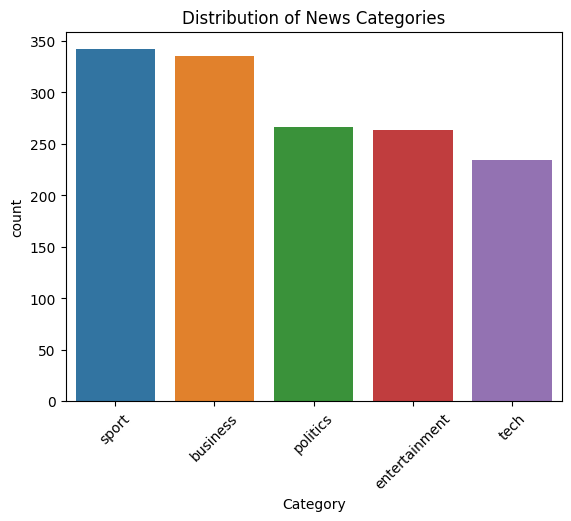

In [12]:
# View distribution of article categories
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.title("Distribution of News Categories")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


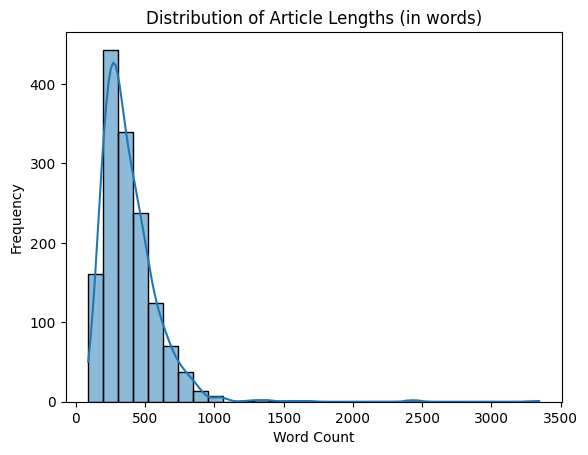

In [13]:
# Calculate article lengths
df['Text_Length'] = df['Text'].apply(lambda x: len(x.split()))

# Plot article length distribution
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Article Lengths (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [14]:
train_stats = df[['Text', 'Category']]
train_stats['word_count'] = train_stats.Text.apply(lambda x: len(x.split()))
train_stats[['Category', 'word_count']].groupby('Category').describe()

<ipython-input-14-2798179457aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_stats['word_count'] = train_stats.Text.apply(lambda x: len(x.split()))


word_count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           335.0  334.274627  133.713125  145.0  253.00  304.0   
entertainment      263.0  335.444867  207.134549  144.0  229.00  271.0   
politics           266.0  451.642857  261.490785   90.0  320.25  445.0   
sport              342.0  336.877193  185.930006  116.0  211.50  296.5   
tech               234.0  509.222222  212.922747  188.0  345.25  461.5   

                               
                  75%     max  
Category                       
business       391.50   902.0  
entertainment  380.00  2448.0  
politics       527.75  3345.0  
sport          416.75  1671.0  
tech           633.75  1549.0

After looking at word counts by category we see that politics and tech articles tend to be longer and more variable in length than articles in other categories. This might affect how these articles are clustered, as longer articles may contain more diverse vocabulary and topic coverage.

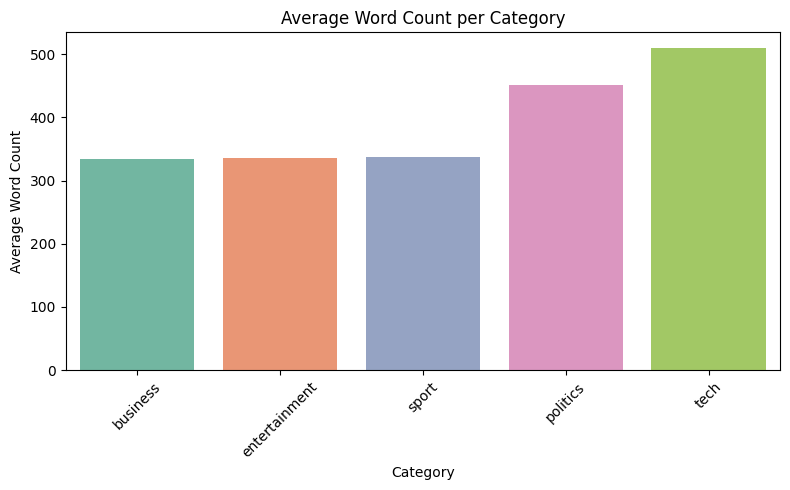

In [15]:
# Calculate mean word count per category
avg_word_counts = train_stats.groupby('Category')['word_count'].mean().sort_values()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_word_counts.index, y=avg_word_counts.values, palette='Set2')
plt.title('Average Word Count per Category')
plt.xlabel('Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Next, we turn all of the news articles into numerical vectors that represent the importance of each word and phrase. These vectors are then used as input for clustering models.

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), 
                        stop_words='english')


features = tfidf.fit_transform(df['Text']).toarray()  # or df['Clean_Text'] if using cleaned text


labels = df['Category']


In [17]:
# converts article categories from text to numbers so we can use them in evaluation metrics and machine learning models that require numeric input.
# Convert text labels to numeric IDs
label_encoder = LabelEncoder()
df['Category_ID'] = label_encoder.fit_transform(df['Category'])

# Now you can use this numeric version if needed
labels = df['Category_ID']


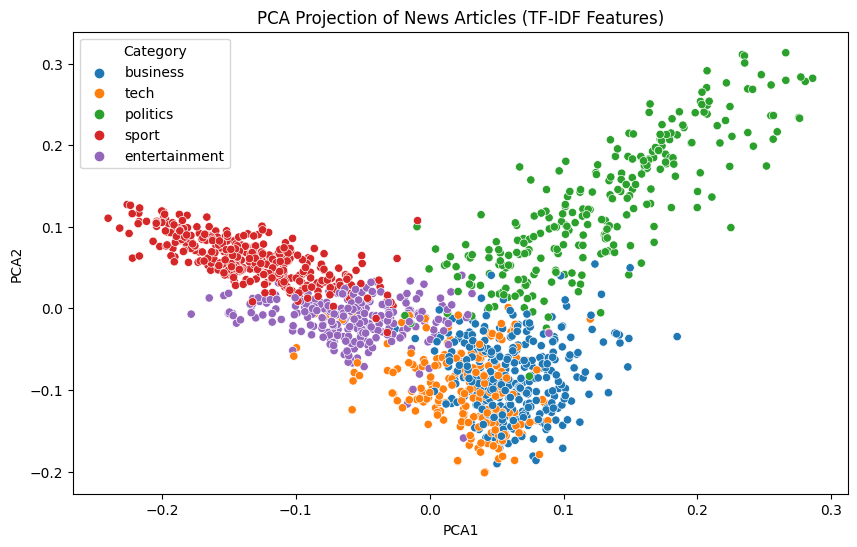

In [18]:
# Apply PCA to reduce TF-IDF vectors to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Add to DataFrame for plotting
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot using true categories (only for visual reference)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Category', palette='tab10')
plt.title('PCA Projection of News Articles (TF-IDF Features)')
plt.show()


In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english')

features = tfidf.fit_transform(df['Text']).toarray()

# Apply PCA to reduce TF-IDF vectors to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)  # make sure 'features' is defined too!

### Elbow Method 

To determine the optimal number of clusters, we apply the Elbow Method by calculating the inertia for values of k ranging from 2 to 10.

As shown in the plot, inertia decreases as we increase k. However, the rate of improvement slows down significantly after k = 5, forming a visible elbow shape.

This suggests that k = 5 is a good pick.

Interestingly, this also aligns with the actual number of news categories in the dataset, which further supports choosing 5 clusters.


Text(0, 0.5, 'Inertia')

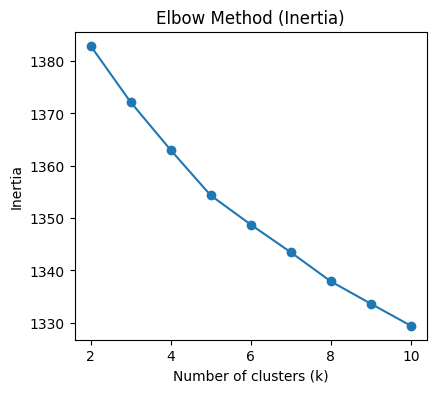

In [20]:
# Try different numbers of clusters and record inertia
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features, kmeans.labels_))

# Plot Inertia (Elbow Curve)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')



In [21]:
# Function to apply K-Means and create plot
def plot_kmeans(k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_pca)

    fig = px.scatter(
        x=X_pca[:, 0], y=X_pca[:, 1], color=clusters.astype(str),
        title=f"K-Means Clustering with K={k}", labels={"x": "PCA1", "y": "PCA2"}
    )

    # Add cluster centroids
    fig.add_trace(go.Scatter(
        x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
        mode='markers', marker=dict(color='red', size=12, symbol='x'),
        name='Centroids'
    ))

    fig.show()

# Create interactive slider widget
k_slider = widgets.IntSlider(value=5, min=2, max=10, step=1, description='K:')
widgets.interactive(plot_kmeans, k=k_slider)
#kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#clusters = kmeans.fit_predict(X_pca)


interactive(children=(IntSlider(value=5, description='K:', max=10, min=2), Output()), _dom_classes=('widget-in…

Next we will evaluate the clustering quality from two perspectives:

Cosine Similarity shows how similar articles are within each cluster where higher scores mean tighter, more cohesive clusters.

ARI and Homogeneity Score compare our cluster assignments to the real news categories (labels), even though I didn't use them to train the model. High scores indicate our unsupervised model discovered meaningful structure.

In [22]:
kmeans = KMeans(n_clusters=5, random_state=42,  n_init=10)
df['Cluster'] = kmeans.fit_predict(X_pca)

In [23]:
cos_sim_matrix = cosine_similarity(features)  # or use X_reduced if using SVD

for cluster_id in sorted(df['Cluster'].unique()):
    idxs = df[df['Cluster'] == cluster_id].index
    cluster_sim = cos_sim_matrix[np.ix_(idxs, idxs)]
    n = len(idxs)
    if n > 1:
        avg_sim = (np.sum(cluster_sim) - n) / (n * (n - 1))  # Exclude diagonal
        print(f"Cluster {cluster_id}: Avg Cosine Similarity = {avg_sim:.4f}")
    else:
        print(f"Cluster {cluster_id}: Only 1 article")


Cluster 0: Avg Cosine Similarity = 0.0445
Cluster 1: Avg Cosine Similarity = 0.0548
Cluster 2: Avg Cosine Similarity = 0.0486
Cluster 3: Avg Cosine Similarity = 0.0354
Cluster 4: Avg Cosine Similarity = 0.1188


In [24]:
ari = adjusted_rand_score(df['Category_ID'], df['Cluster'])
homo = homogeneity_score(df['Category_ID'], df['Cluster'])

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Homogeneity Score: {homo:.3f}")


Adjusted Rand Index: 0.541
Homogeneity Score: 0.607


### Hierarchical Clustering

Initially, I applied hierarchical clustering using cosine distance as the metric for pairwise document comparison. This made intuitive sense for high-dimensional TF-IDF text data, since cosine similarity is commonly used in natural language processing tasks to capture directional similarity between documents.

Surprisingly, the cosine-based clustering achieved relatively high scores on evaluation metrics like Adjusted Rand Index (ARI) and Homogeneity Score, particularly when using Ward linkage. However, the resulting clusters were visually imbalanced — with most data points collapsed into a single cluster — and did not reflect the true structure of the dataset as revealed through PCA.

After further testing, I learnt that Ward linkage is specifically designed for Euclidean distance, as it minimizes the total within-cluster variance. Using cosine distance with Ward violates this assumption and can lead to unstable results, even if evaluation metrics appear superficially strong.

To address this, I repeated the experiment using Euclidean distance, ensuring compatibility with Ward and the other linkage methods. Below is the updated clustering pipeline using Euclidean distance across all linkage methods, along with dendrogram visualizations and clustering performance evaluation:




Linkage method: ward


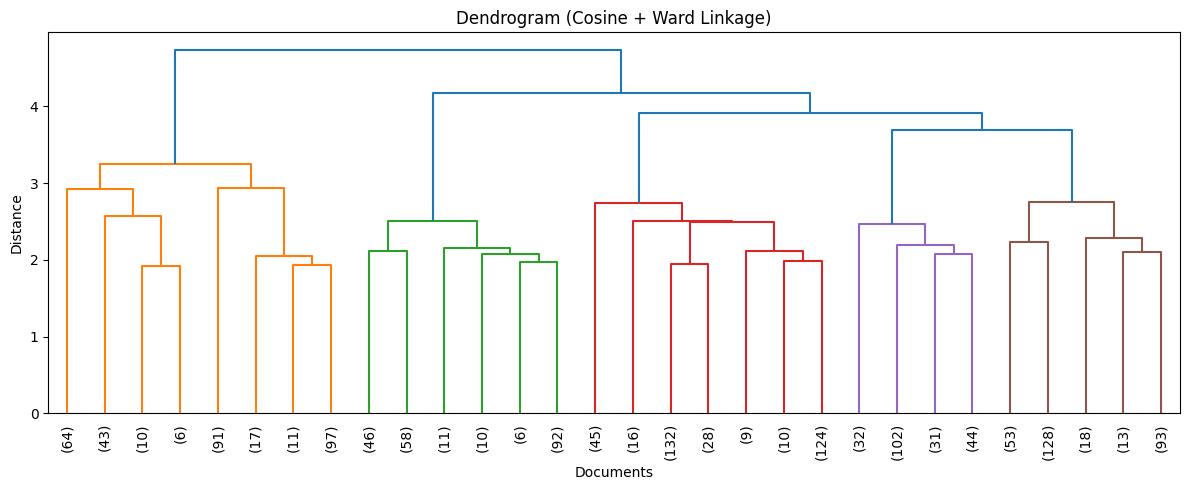

Adjusted Rand Index (ARI): 0.7990
Homogeneity Score: 0.7724

Linkage method: average


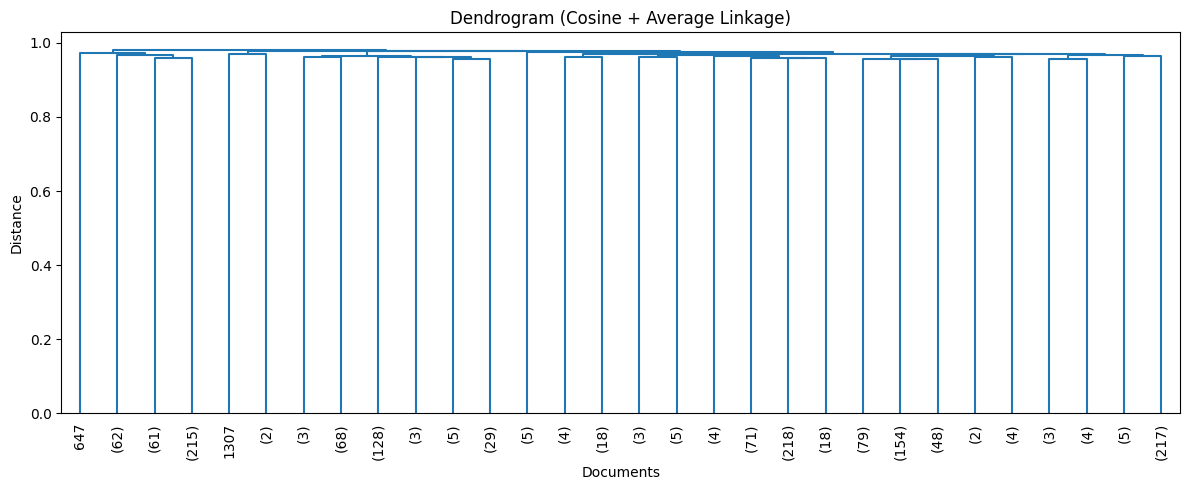

Adjusted Rand Index (ARI): 0.4478
Homogeneity Score: 0.5249

Linkage method: complete


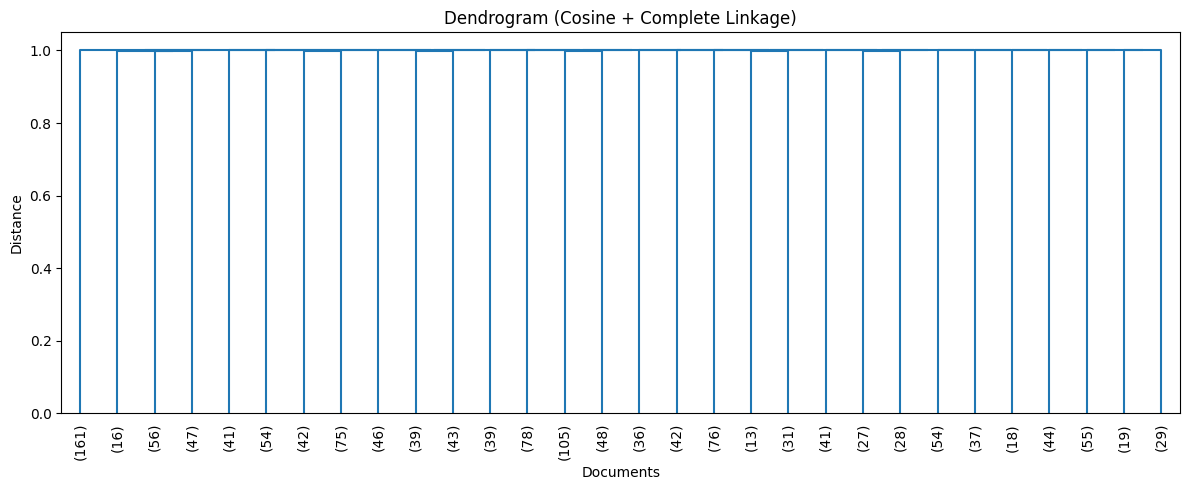

Adjusted Rand Index (ARI): 0.0000
Homogeneity Score: 0.0000

Linkage method: single


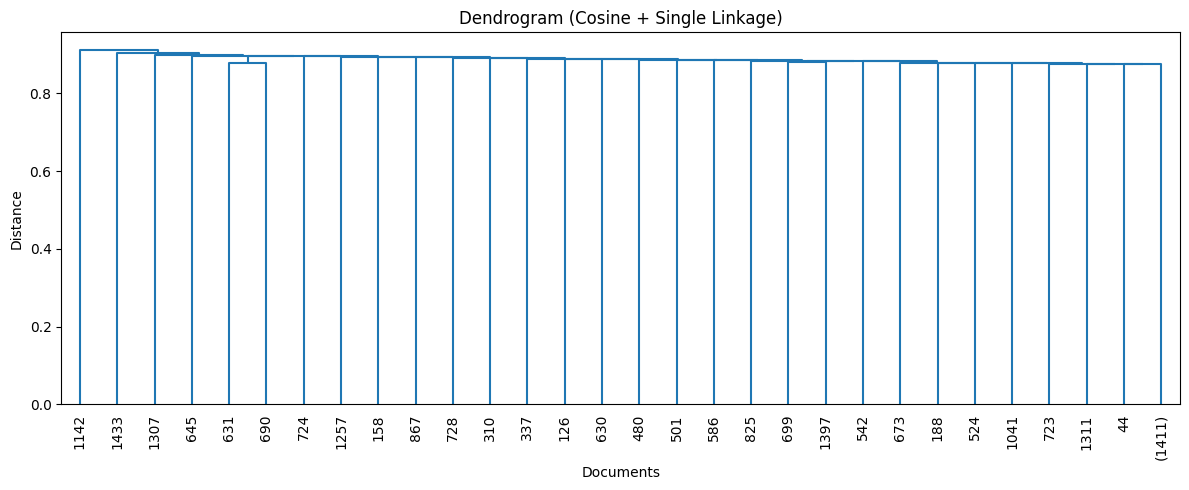

Adjusted Rand Index (ARI): 0.0004
Homogeneity Score: 0.0030


In [25]:
# Make sure your features are defined (TF-IDF)
# If needed: features = tfidf.fit_transform(df['Text']).toarray()

# Step 1: Compute cosine distance matrix
distance_matrix = pdist(features, metric='cosine')

# Step 2: Try different linkage methods
linkage_methods = ['ward','average', 'complete', 'single']

for method in linkage_methods:
    print(f"\nLinkage method: {method}")
    
    # Step 3: Build linkage matrix
    linkage_matrix = linkage(distance_matrix, method=method)

    # Optional: Plot dendrogram
    plt.figure(figsize=(12, 5))
    dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10)
    plt.title(f"Dendrogram (Cosine + {method.capitalize()} Linkage)")
    plt.xlabel("Documents")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # Step 4: Cut the dendrogram into k clusters
    k = 5
    df['Cluster'] = fcluster(linkage_matrix, t=k, criterion='maxclust')

    # Step 5: Evaluate clustering
    ari = adjusted_rand_score(df['Category_ID'], df['Cluster'])
    homo = homogeneity_score(df['Category_ID'], df['Cluster'])

    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Homogeneity Score: {homo:.4f}")



Linkage method: ward


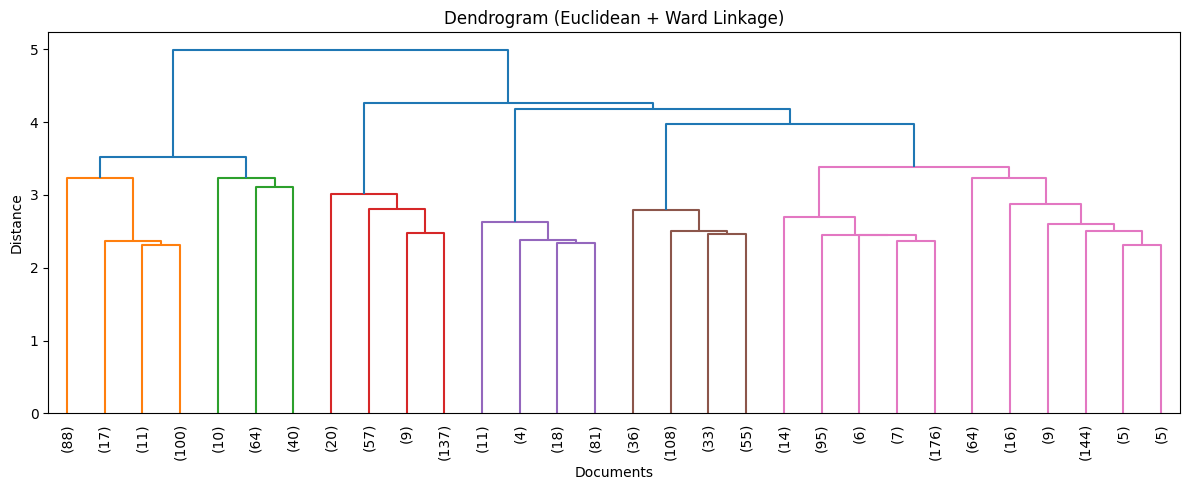

Adjusted Rand Index (ARI): 0.6340
Homogeneity Score: 0.6779

Linkage method: average


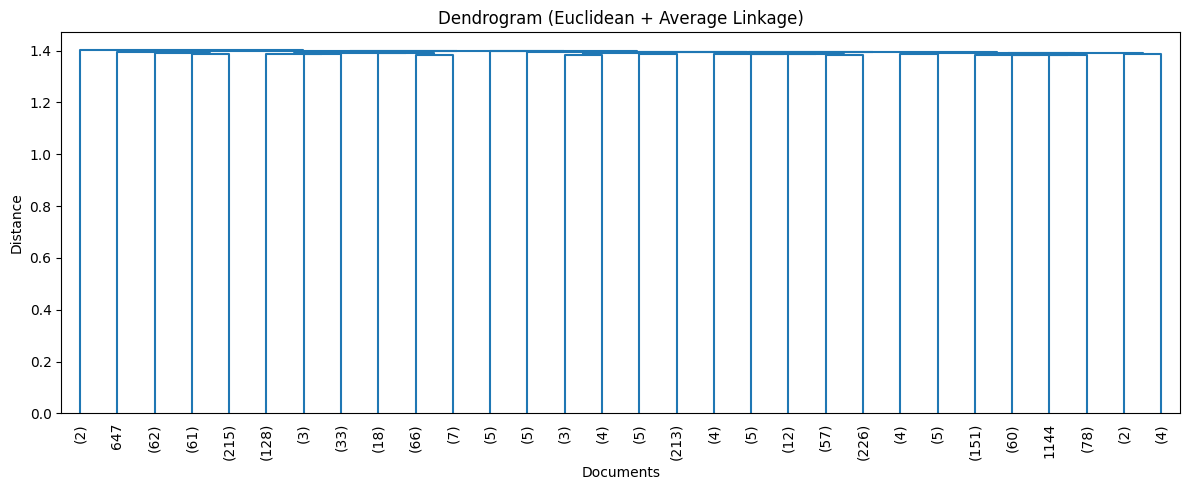

Adjusted Rand Index (ARI): 0.4652
Homogeneity Score: 0.5320

Linkage method: complete


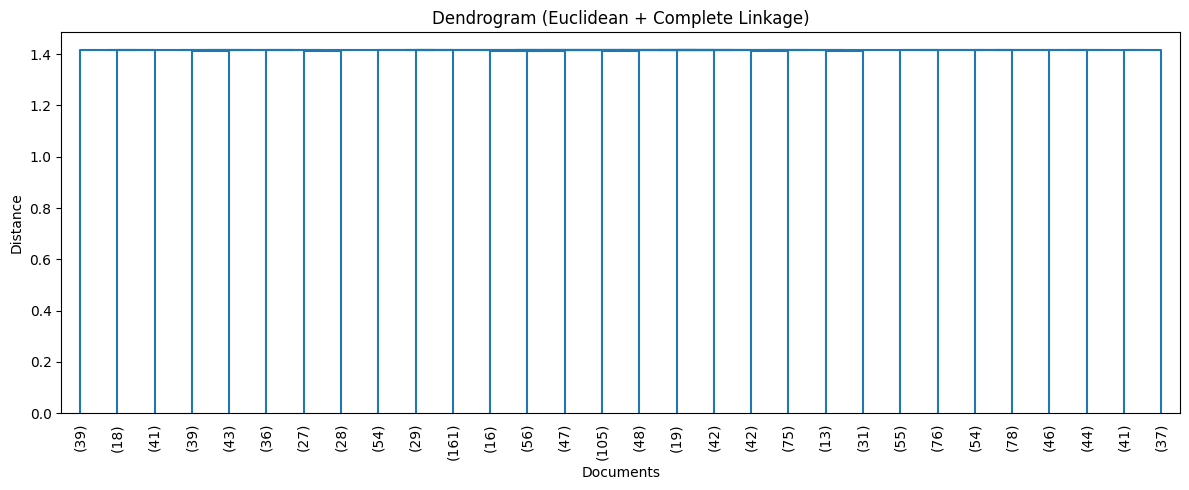

Adjusted Rand Index (ARI): 0.1820
Homogeneity Score: 0.2572

Linkage method: single


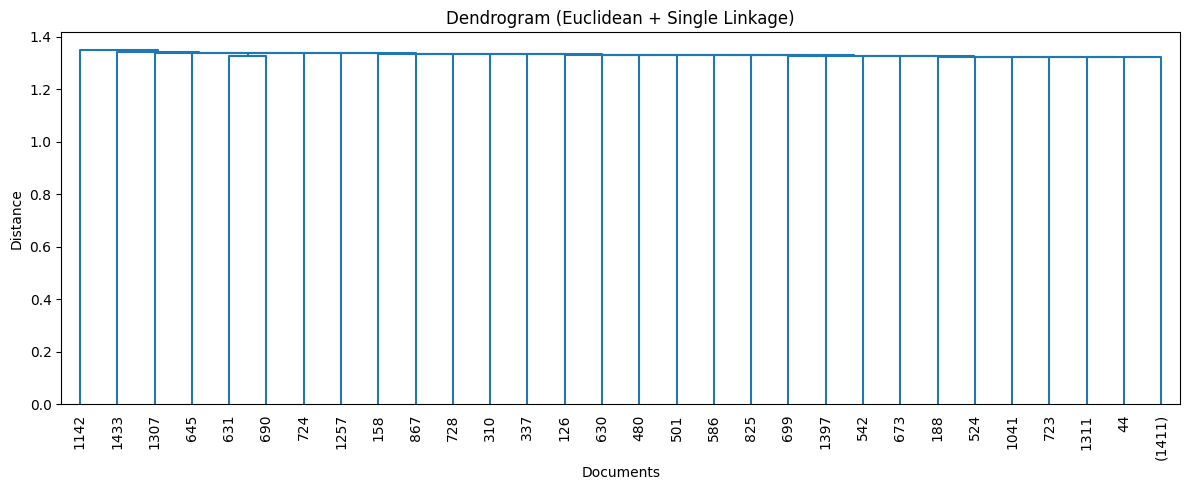

Adjusted Rand Index (ARI): 0.0004
Homogeneity Score: 0.0030


In [26]:
#Compute Euclidean distance matrix
distance_matrix = pdist(features, metric='euclidean')

# Try different linkage methods with Euclidean distance
linkage_methods = ['ward', 'average', 'complete', 'single']

for method in linkage_methods:
    print(f"\nLinkage method: {method}")

    # Step 3: Build linkage matrix
    linkage_matrix = linkage(distance_matrix, method=method)

    # Optional: Plot dendrogram
    plt.figure(figsize=(12, 5))
    dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10)
    plt.title(f"Dendrogram (Euclidean + {method.capitalize()} Linkage)")
    plt.xlabel("Documents")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # Step 4: Cut the dendrogram into k clusters
    k = 5
    df['Cluster'] = fcluster(linkage_matrix, t=k, criterion='maxclust')

    # Step 5: Evaluate clustering
    ari = adjusted_rand_score(df['Category_ID'], df['Cluster'])
    homo = homogeneity_score(df['Category_ID'], df['Cluster'])

    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Homogeneity Score: {homo:.4f}")


### Linkage Method Comparison

After testing the four linkage strategies with hierarchical clustering using cosine & euclidean distance. Among them, Ward linkage produced the strongest clusters, with an Adjusted Rand Index of 0.799 and a homogeneity score of 0.772 for cosine method and Adjusted Rand Index of 0.634 and a homogeneity score of 0.678. The dendrogram for Ward clearly showed well-separated branches, indicating meaningful cluster structure.

In contrast, Average, Complete, and Single linkage did not do as well to form distinct groupings. Their dendrograms were mostly flat, and they produced very low evaluation scores.

Using these results we can conclude that Ward linkage is the most suitable method for clustering news articles in this dataset.


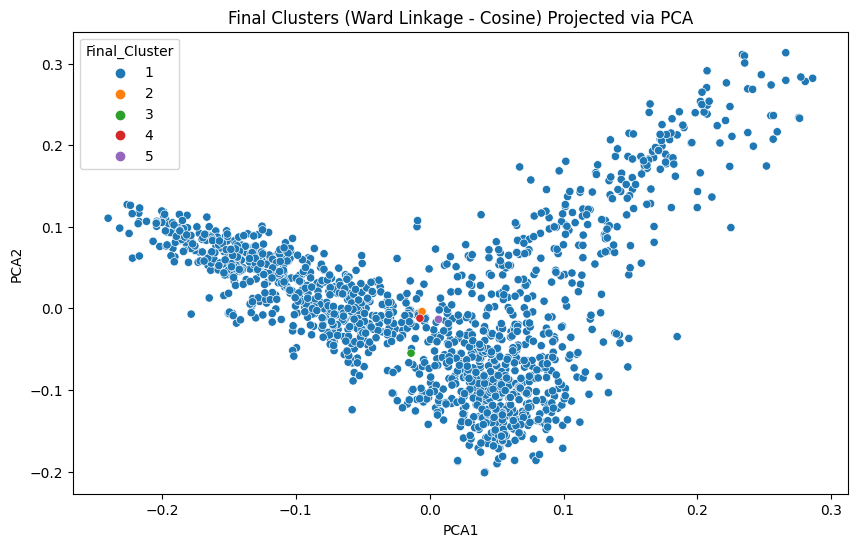

In [27]:
# Cut the dendrogram to form 5 clusters
df['Final_Cluster'] = fcluster(linkage_matrix, t=5, criterion='maxclust')



plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['Final_Cluster'], palette='tab10')
plt.title("Final Clusters (Ward Linkage - Cosine) Projected via PCA")
plt.show()



In [28]:
df['Final_Cluster'].value_counts()

Final_Cluster
1    1436
2       1
5       1
3       1
4       1
Name: count, dtype: int64

In [29]:
# Make sure 'features' is your TF-IDF matrix (dense)
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(features)


# Apply KMeans with K=5 (final version)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_pca)


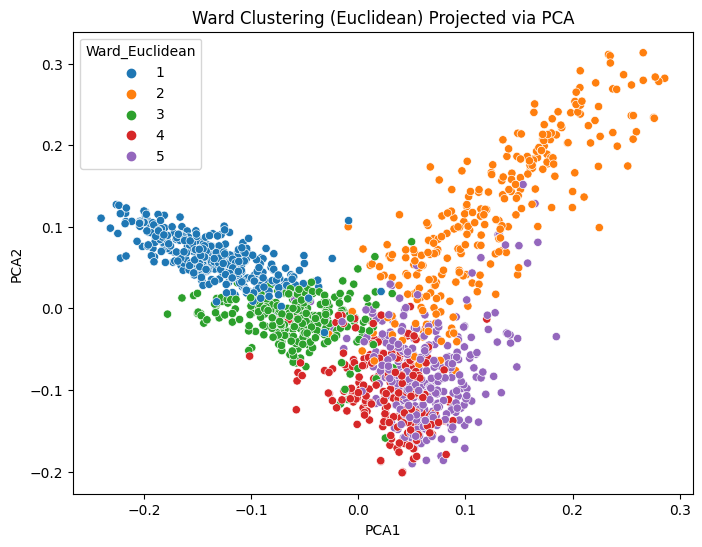

In [30]:
# Use PCA or TruncatedSVD reduced data (dense)
linkage_matrix = linkage(X_reduced, method='ward')  # uses Euclidean automatically

# Cut the dendrogram to form 5 clusters
df['Ward_Euclidean'] = fcluster(linkage_matrix, t=5, criterion='maxclust')

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Ward_Euclidean', data=df, palette='tab10')
plt.title("Ward Clustering (Euclidean) Projected via PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


In [31]:
df['Ward_Euclidean'].value_counts()

Ward_Euclidean
1    336
5    330
2    278
3    266
4    230
Name: count, dtype: int64

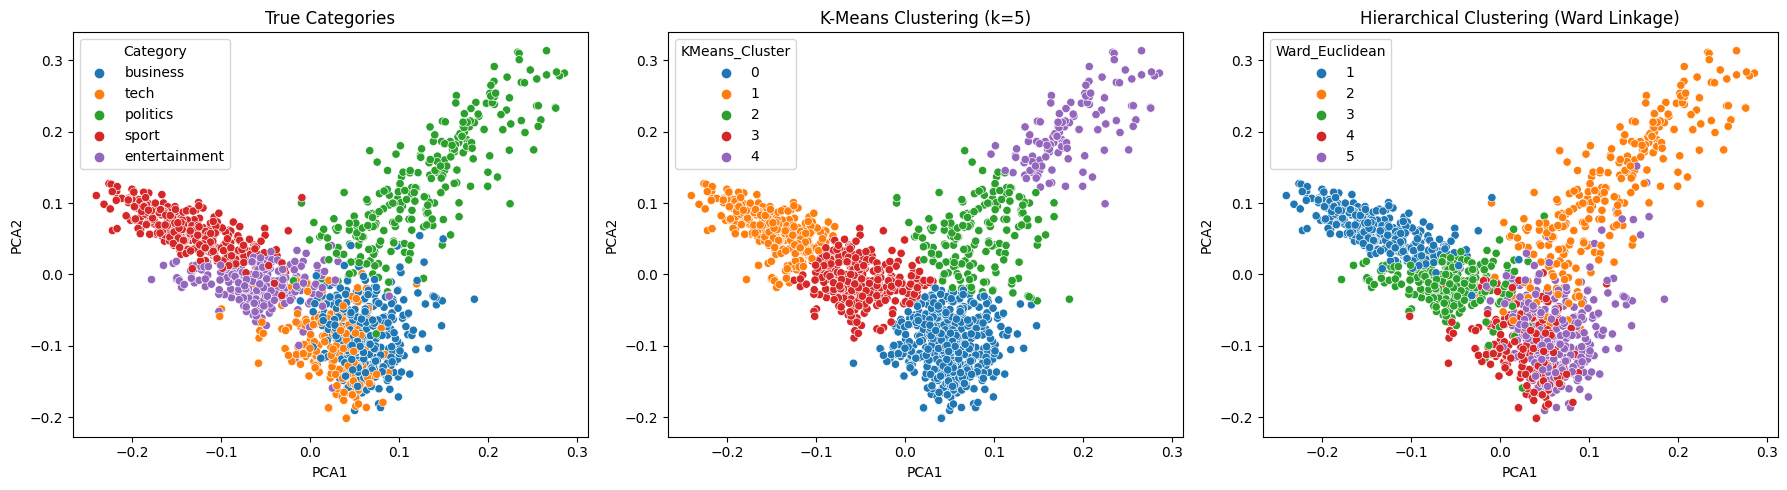

In [32]:
plt.figure(figsize=(18, 5))

# 1. True categories
plt.subplot(1, 3, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='Category', data=df, palette='tab10')
plt.title("True Categories")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 2. K-Means clustering
plt.subplot(1, 3, 2)
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df, palette='tab10')
plt.title("K-Means Clustering (k=5)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# 3. Hierarchical clustering
plt.subplot(1, 3, 3)
sns.scatterplot(x='PCA1', y='PCA2', hue='Ward_Euclidean', data=df, palette='tab10')
plt.title("Hierarchical Clustering (Ward Linkage)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()


In the plot above, we compare:

* True Categories -ground-truth labels of each news article.

* KMeans Clustering -using TF-IDF features reduced via PCA with k=5.

* Hierarchical Clustering (Ward Linkage + Euclidean)-properly tuned with the correct distance metric.

All three projections are visualized using the same PCA-reduced 2D space.

* KMeans forms clear, well-separated clusters that closely match the actual categories.

* Ward (Euclidean) also performs well, producing reasonably balanced clusters with similar structure to the labeled data.

* Both clustering methods capture the underlying topic-based separation in the articles, confirming the strength of unsupervised learning on TF-IDF-based text data.

## Conclusion

In this project, I explored unsupervised learning for news article clustering using a labeled BBC dataset. My goal was to apply clustering algorithms to uncover hidden groupings in the data, independent of the true labels.

After performing text preprocessing and transforming the article content into TF-IDF feature vectors, I applied two main clustering methods:
- KMeans, using an elbow method to select k = 5
- Hierarchical Clustering, tested with multiple linkage strategies

I then evaluated both models using internal metrics like silhouette score and external metrics like Adjusted Rand Index (ARI) and Homogeneity Score, using the provided labels for reference.

KMeans emerged as a strong performer, forming distinct and balanced clusters that aligned with the actual news categories for the most part. It scored higher on numeric evaluation metrics like ARI and homogeneity. Meanwhile,after correcting for distance metric usage, Ward linkage with Euclidean distance also performed competitively, producing clusters that were more visually aligned with the true categories when projected into 2D space using PCA.

Through this process, I:
- Demonstrated the use of unsupervised learning on real-world text data
- Explored model tuning and evaluation techniques
- Validated clustering quality using both metrics and visualization
